In [1]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 50
        _num2           = 50
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.ReLU(True))
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()
        self.fc3.bias.data.zero_()
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        #self._initialize_weight()        
        
    def _initialize_weight(self):
        #Linear = m.__class__.__name__
        for m in self.modules():
            
            n = m.in_features
            
            m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

            if m.bias is not None:

                m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [2]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
from torch.optim.lr_scheduler import StepLR
# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------

batch_size = 10
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		
# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])
train_data_path = 'horse-or-human/horse-or-human/train'
set_train   =   torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
loader_train = torch.utils.data.DataLoader(set_train, batch_size=batch_size, shuffle=True, num_workers=0)  


validation_data_path = 'horse-or-human/horse-or-human/validation'
set_test   =   torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
loader_test = torch.utils.data.DataLoader(set_test, batch_size=batch_size, shuffle=False, num_workers=0)


num_classes = 2

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

#from Linear import *
model = Linear(num_classes=num_classes)
#model.apply(_initialize_weight)
# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 0

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

learning_rate = 1e-4
optimizer   = optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-3)
objective   = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)
# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    # print('train the model at given epoch')

    loss_train          = []
    accuracy_train      = []
    correct         = 0
    total_train     = 0
    model.train()

    for idx_batch, (data, target) in enumerate(loader_train):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        
        
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()
        total_train += target.nelement()
        
        accuracy_train.append(100. * float(correct) / total_train)
        
    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    accuracy_train_mean     = np.mean (accuracy_train)
    accuracy_train_std      = np.std (accuracy_train)
    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train_mean': accuracy_train_mean , 'accuracy_train_std' : accuracy_train_std  }

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(loader_test.dataset)
    accuracy_test   = 100. * float(correct) / len(loader_test.dataset)
    
    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

epoch = 200

loss_train_mean = []
loss_train_std = []
loss_test = []
accuracy_test = []
accuracy_train_mean = []
accuracy_train_std = []
for e in range(epoch):
      
    result_train    = train()
    result_test     = test()
    
    scheduler.step()  
    
    print('[epoch ' + str(e) + ']',end='')
    print(' loss:(training)' + str(result_train['loss_train_mean']) + ' (testing)'+ str(result_test['loss_test']),end= '')
    print(' accuracy:(training)'+str(result_train['accuracy_train_mean'])+'(testing)'+str(result_test['accuracy_test']))
    
    loss_train_mean.append(result_train['loss_train_mean'])
    loss_train_std.append(result_train['loss_train_std'])
    loss_test.append(result_test['loss_test'])
    accuracy_test.append(result_test['accuracy_test'])
    accuracy_train_mean.append(result_train['accuracy_train_mean'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    


[epoch 0] loss:(training)0.06824390021838693 (testing)0.06348862068261951 accuracy:(training)57.474623988666636(testing)66.40625
[epoch 1] loss:(training)0.06401091865296173 (testing)0.058957027504220605 accuracy:(training)59.92763528000171(testing)71.875
[epoch 2] loss:(training)0.061538424707649496 (testing)0.05275475233793259 accuracy:(training)64.56205801468334(testing)81.640625
[epoch 3] loss:(training)0.0594020257338406 (testing)0.049659626092761755 accuracy:(training)70.05592394967547(testing)83.984375
[epoch 4] loss:(training)0.057601253128250166 (testing)0.04830353788565844 accuracy:(training)74.18334423940391(testing)81.25
[epoch 5] loss:(training)0.056247169845808576 (testing)0.044705481559503824 accuracy:(training)70.65493520554845(testing)84.765625
[epoch 6] loss:(training)0.05501837920547358 (testing)0.043203699169680476 accuracy:(training)74.36592264779004(testing)85.9375
[epoch 7] loss:(training)0.0540389572615101 (testing)0.041736399580258876 accuracy:(training)74.3413

[epoch 63] loss:(training)0.042889722532769695 (testing)0.031217311581713147 accuracy:(training)80.83939528970282(testing)87.109375
[epoch 64] loss:(training)0.04293966008538842 (testing)0.031212610978400335 accuracy:(training)81.01833635841605(testing)87.109375
[epoch 65] loss:(training)0.04308161009283899 (testing)0.031235014379490167 accuracy:(training)79.77448660872749(testing)87.109375
[epoch 66] loss:(training)0.04297512386319706 (testing)0.031240435142535716 accuracy:(training)81.06300312071666(testing)87.109375
[epoch 67] loss:(training)0.04279006587318178 (testing)0.031244472789694555 accuracy:(training)80.46284507259936(testing)87.109375
[epoch 68] loss:(training)0.042817564969998625 (testing)0.03127389070868958 accuracy:(training)80.78696314642178(testing)86.71875
[epoch 69] loss:(training)0.042970314960869935 (testing)0.03130523004801944 accuracy:(training)81.36824715587177(testing)87.109375
[epoch 70] loss:(training)0.042870382468594606 (testing)0.031246809085132554 accura

[epoch 126] loss:(training)0.04234051340868008 (testing)0.031007594981929287 accuracy:(training)81.79939631956198(testing)87.5
[epoch 127] loss:(training)0.042315298827279794 (testing)0.031005723183625378 accuracy:(training)79.81178091259963(testing)87.5
[epoch 128] loss:(training)0.04253982712880252 (testing)0.031004407675936818 accuracy:(training)80.31839650863799(testing)87.5
[epoch 129] loss:(training)0.042386789070171065 (testing)0.0310039378964575 accuracy:(training)78.36266173950409(testing)87.5
[epoch 130] loss:(training)0.04229218783309158 (testing)0.031003949654405005 accuracy:(training)83.85876494404218(testing)87.5
[epoch 131] loss:(training)0.042322004453153775 (testing)0.03100310210720636 accuracy:(training)80.83457897610641(testing)87.5
[epoch 132] loss:(training)0.042282769976806384 (testing)0.0310032357374439 accuracy:(training)81.64010484379361(testing)87.5
[epoch 133] loss:(training)0.042354537815310254 (testing)0.03100306801206898 accuracy:(training)79.86537121066(t

[epoch 190] loss:(training)0.042457603234358536 (testing)0.03099691115494352 accuracy:(training)79.42368155509021(testing)87.5
[epoch 191] loss:(training)0.04241685399400708 (testing)0.03099687040958088 accuracy:(training)82.1786064569601(testing)87.5
[epoch 192] loss:(training)0.0422789646914531 (testing)0.030996992529253475 accuracy:(training)81.6820451963269(testing)87.5
[epoch 193] loss:(training)0.042231423553497884 (testing)0.03099709733214695 accuracy:(training)80.48140800513107(testing)87.5
[epoch 194] loss:(training)0.04211669399321658 (testing)0.0309970467351377 accuracy:(training)79.20141767649797(testing)87.5
[epoch 195] loss:(training)0.04223898380333442 (testing)0.03099697013385594 accuracy:(training)81.81718138135308(testing)87.5
[epoch 196] loss:(training)0.04236849004327837 (testing)0.030996785179013386 accuracy:(training)81.60378392797692(testing)87.5
[epoch 197] loss:(training)0.04220930164300122 (testing)0.03099669901712332 accuracy:(training)79.55076950410252(testi

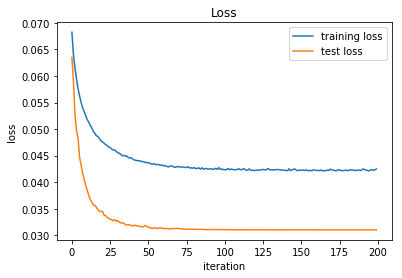

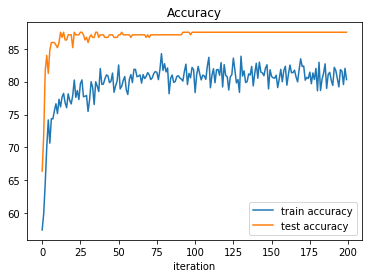

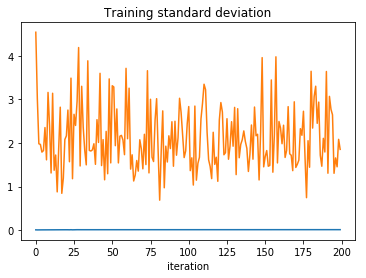

In [4]:
import matplotlib.pyplot as plt 
plt.plot(loss_train_mean,label = "training loss")
plt.plot(loss_test,label="test loss")
plt.xlabel('iteration')
plt.ylabel('loss') 
plt.title('Loss')
plt.legend() 
plt.show() 

plt.plot(accuracy_train_mean,label="train accuracy")
plt.plot(accuracy_test,label="test accuracy")
plt.xlabel('iteration')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(loss_train_std,label = "loss std")
plt.title('Training standard deviation')
plt.xlabel('iteration')
plt.legend
plt.show()


plt.plot(accuracy_train_std,label=" accuracy std")
plt.title('Training accuracy standard deviation')
plt.legend

In [ ]:
print("\t\ttraining\t\ttest\t\t")
print("=================================================================================")
print("loss\t\t"+"{0:.10f}".format(loss_train_mean[-1])+"\t\t"+"{0:.10f}".format(loss_test[-1])+"\t\t")
print("=================================================================================")
print("accuracy\t"+"{0:.10f}".format(accuracy_train[-1])+"\t\t"+ "{0:.10f}".format(accuracy_test[-1])+"\t\t")